# **Step 5 : Mini-Taxonomy of Definitions**

**Goal**: Extract and classify definitions of "Agentic AI" in the corpus

**Hybrid approach**:
1. **Semi-automatic extraction** - Identify definition paragraphs
2. **Manual classification** - Group into conceptual categories
3. **Visualization** - Tables and diagrams (treemap, sunburst)

**Expected categories**:
- AI as Copilots/Assistants
- AI as Autonomous Workers
- AI as Multi-Agent Ecosystems/Orchestrators
- AI as Governance/Risk Challenges

**Output**: Taxonomy of definitions + report visualizations

## Setup Config & Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Imports
import json
import re
from pathlib import Path
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.tokenize import sent_tokenize

# Viz
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("✔ Imports")

✔ Imports


## Load processed corpus

In [2]:
# Paths
PROJECT_ROOT = Path.cwd().parent
PROCESSED_DATA = PROJECT_ROOT / "data" / "processed"
TEXTS_DIR = PROCESSED_DATA / "texts"
METADATA_FILE = PROCESSED_DATA / "metadata" / "corpus_metadata.json"

# Create taxonomy folder
TAXONOMY_DIR = PROCESSED_DATA / "taxonomy"
TAXONOMY_DIR.mkdir(exist_ok=True)

print(f"Taxonomy folder : {TAXONOMY_DIR}")

Taxonomy folder : c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy


In [3]:
# Load raw texts
texts = {}
with open(METADATA_FILE, 'r', encoding='utf-8') as f:
    metadata = json.load(f)

for doc_id in metadata.keys():
    text_file = TEXTS_DIR / f"{doc_id}.txt"
    if text_file.exists():
        with open(text_file, 'r', encoding='utf-8') as f:
            texts[doc_id] = f.read()

print(f"✔ {len(texts)} documents loaded")

✔ 20 documents loaded


In [4]:
# Mapping doc_id -> source_type
doc_to_source = {doc_id: metadata[doc_id]['source_type'] 
                 for doc_id in texts.keys()}

## 📝 Quick text cleaning

In [5]:
def advanced_text_cleaning(text):
    """
    Clean text for extraction of definitions.
    
    Remove:
    - (cid:XX) -like wrong encoding
    - Headers/footers
    - Figures and tables
    - Biblio refs
    - URLs and emails
    - Lines too short (< 10 words)
    """
    text = re.sub(r'\(cid:\d+\)', '', text)
    text = re.sub(r'\[\d+\]', '', text)  # [1], [23]
    text = re.sub(r'\d+\s+\|', '', text)  # Page numbers with pipes
    
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    
    text = re.sub(r'FIGURE\s+\d+[^\n]*\n', '', text, flags=re.IGNORECASE)
    text = re.sub(r'TABLE\s+\d+[^\n]*\n', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Figure\s+\d+:', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Table\s+\d+:', '', text, flags=re.IGNORECASE)
    
    text = re.sub(r'Note:\s*[^\n]*', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Source:\s*[^\n]*', '', text, flags=re.IGNORECASE)
    
    text = re.sub(r'©\s*\d{4}.*?\n', '', text)
    text = re.sub(r'All rights reserved.*?\n', '', text, flags=re.IGNORECASE)
    
    text = re.sub(r'\s+', ' ', text)
    
    lines = text.split('\n')
    cleaned_lines = []
    
    for line in lines:
        line = line.strip()
        
        if len(line.split()) < 10:
            continue
        
        words = line.split()
        num_count = sum(1 for w in words if w.isdigit() or any(c.isdigit() for c in w))
        if num_count > len(words) * 0.5:
            continue
        
        if line.count(',') > len(words) * 0.3:
            continue
        
        cleaned_lines.append(line)
    
    cleaned_text = ' '.join(cleaned_lines)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

In [6]:
texts_cleaned = {}
total_reduction = 0

for doc_id, text in texts.items():
    cleaned = advanced_text_cleaning(text)
    texts_cleaned[doc_id] = cleaned
    
    reduction = (len(text) - len(cleaned)) / len(text) * 100
    total_reduction += reduction
    
    filename = metadata[doc_id]['filename']
    print(f"\n{filename}")
    print(f"   Before: {len(text):,} characters")
    print(f"   After: {len(cleaned):,} characters")
    print(f"   Reduction: {reduction:.1f}%")

avg_reduction = total_reduction / len(texts)
print(f"Average reduction: {avg_reduction:.1f}%")


Bain_report_technology_report_2025.pdf
   Before: 134,654 characters
   After: 10,669 characters
   Reduction: 92.1%

BCG_AI_Agents_2025.pdf
   Before: 10,362 characters
   After: 10,362 characters
   Reduction: 0.0%

Deloitte_The_business_imperative_for_Agentic_AI_2025.pdf
   Before: 158,368 characters
   After: 25,011 characters
   Reduction: 84.2%

Google_Agentic_AI_TAM_Analysis_2025.pdf
   Before: 154,199 characters
   After: 17,310 characters
   Reduction: 88.8%

Google_The_ROI_of_AI_2025.pdf
   Before: 8,597 characters
   After: 8,597 characters
   Reduction: 0.0%

Harvard_Designing_a_Successful_Agentic_AI_System_2025.pdf
   Before: 17,627 characters
   After: 17,627 characters
   Reduction: 0.0%

ITI_Understanding_Agentic_AI_Policy_Guide_2025.pdf
   Before: 43,410 characters
   After: 41,901 characters
   Reduction: 3.5%

McKinsey_Empowering_advanced_industries_with_agentic_AI_2025.pdf
   Before: 18,082 characters
   After: 18,082 characters
   Reduction: 0.0%

McKinsey_The_age

In [7]:
texts = texts_cleaned

## Semi-automatic extraction of definition

### Extraction strategy

Here, we will extract the definitions of agentic AI, autonomous agents, and AI agents from the text. To do so, we will identify the phrases/paragraphs which:
1. Contain the key terms: "agentic ai", "ai agent", "autonomous agent"
2. Use definition markers: "is", "are", "defined as", "refers to", "means"
3. Are in the first sections (introduction, definitions)

In [8]:
def extract_definition_candidates(text, doc_id):
    """
    Extract candidate phrases as definitions.
    
    Criterias:
    - Contains key terms (agentic, agent, autonomous)
    - Contains definitional markers
    - Reasonable length (30-300 words)
    """
    # Tokenize in phrases
    sentences = sent_tokenize(text)
    
    key_terms = [
        r'\bagentic\s+ai\b',
        r'\bai\s+agent[s]?\b',
        r'\bautonomous\s+agent[s]?\b',
        r'\bagentic\s+system[s]?\b',
        r'\bintelligent\s+agent[s]?\b',
        r'\bagent[s]?\s+(are|is|can|enable|provide|represent)\b',
        r'\bagentic\s+(capability|capabilities|approach)\b'
    ]
    
    def_markers = [
        r'\b(is|are)\s+defined\s+as\b',
        r'\brefers?\s+to\b',
        r'\bmeans?\b',
        r'\b(can|may)\s+be\s+(understood|described|characterized)\s+as\b',
        r'\b(is|are)\s+characterized\s+by\b',
        r'\bconsists?\s+of\b',
        r'\benables?\b',
        r'\b(is|are)\s+capable\s+of\b',
        r'\brepresents?\b',
        r'\b(involve|involves|involving)\b',
        r'\b(enable|enables|enabling)\b'
    ]
    
    exclude_patterns = [
        r'^(figure|table|note|source|appendix|chapter|section)',
        r'^\d+[\.\)]\s',  # Starts with list number
        r'\.\.\.',  # Truncated text
        r'^\(',  # Begins with parenthesis
        r'see (figure|table|appendix)',
        r'shown in (figure|table)',
    ]
    
    candidates = []
    
    for i, sentence in enumerate(sentences):
        sentence_lower = sentence.lower()
        sentence_stripped = sentence.strip()
        
        if len(sentence_stripped) < 50:  # Too short
            continue
        
        if any(re.search(pattern, sentence_lower) for pattern in exclude_patterns):
            continue
        
        if not re.search(r'\b(is|are|can|will|may|enable|provide|represent|allow|support)\b', sentence_lower):
            continue
        
        has_key_term = any(re.search(pattern, sentence_lower) for pattern in key_terms)
        
        if not has_key_term:
            continue
        
        has_def_marker = any(re.search(pattern, sentence_lower) for pattern in def_markers)        
        word_count = len(sentence.split())
        alpha_ratio = sum(c.isalpha() or c.isspace() for c in sentence) / len(sentence)
        
        # Score phrase
        score = 0
        if has_key_term:
            score += 2
            # Bonus if strong key term
            if re.search(r'\bagentic\s+ai\b', sentence_lower):
                score += 1
        
        # Def markers
        if has_def_marker:
            score += 3
        
        # Reasonable length
        if 20 <= word_count <= 200:
            score += 1
        if 40 <= word_count <= 150: 
            score += 1
        
        # Document position (def usually at beginning)
        if i < len(sentences) * 0.2:  # 20% firsts
            score += 2
        elif i < len(sentences) * 0.4:  # 40% firsts
            score += 1
        
        # Text quality
        if alpha_ratio > 0.85:
            score += 1
        
        # Bonus si phrase bien formée (commence par majuscule, finit par ponctuation)
        if sentence[0].isupper() and sentence[-1] in '.!?':
            score += 1
        
        # Seuil plus strict
        if score >= 5:
            # Extraire contexte étendu (phrase précédente et suivante)
            context_parts = []
            
            if i > 0:
                context_parts.append(sentences[i-1])
            
            context_parts.append(sentence)
            
            if i + 1 < len(sentences):
                context_parts.append(sentences[i + 1])
            
            context = ' '.join(context_parts).strip()
            
            candidates.append({
                'doc_id': doc_id,
                'sentence_id': i,
                'text': sentence_stripped,
                'context': context,
                'word_count': word_count,
                'score': score,
                'has_def_marker': has_def_marker,
                'alpha_ratio': alpha_ratio
            })
    
    return candidates

In [9]:
# Extract candidates for docs
all_candidates = []

for doc_id, text in texts.items():
    candidates = extract_definition_candidates(text, doc_id)
    all_candidates.extend(candidates)
    
    filename = metadata[doc_id]['filename']
    print(f"\n{filename}")
    print(f"   {len(candidates)} potential definitions found")

print(f"\n✔ Total: {len(all_candidates)} candidate definitions extracted")


Bain_report_technology_report_2025.pdf
   1 potential definitions found

BCG_AI_Agents_2025.pdf
   16 potential definitions found

Deloitte_The_business_imperative_for_Agentic_AI_2025.pdf
   38 potential definitions found

Google_Agentic_AI_TAM_Analysis_2025.pdf
   19 potential definitions found

Google_The_ROI_of_AI_2025.pdf
   14 potential definitions found

Harvard_Designing_a_Successful_Agentic_AI_System_2025.pdf
   24 potential definitions found

ITI_Understanding_Agentic_AI_Policy_Guide_2025.pdf
   86 potential definitions found

McKinsey_Empowering_advanced_industries_with_agentic_AI_2025.pdf
   23 potential definitions found

McKinsey_The_agentic_organization_contours_of_the_next_paradigm_for_the_AI_era_2025.pdf
   14 potential definitions found

McKinsey_What_is_an_AI_Agent_2025.pdf
   31 potential definitions found

Microsoft_Agent_AI_Towards_a_Holistic_Intelligence_2025.pdf
   5 potential definitions found

MIT_Reimagining_the_future_of_banking_with_agentic_AI_2025.pdf
   7

### Extracted definitions overview

In [10]:
# Create DataFrame
df_candidates = pd.DataFrame(all_candidates)

# Add metadata
df_candidates['filename'] = df_candidates['doc_id'].map(
    lambda x: metadata[x]['filename']
)
df_candidates['source_type'] = df_candidates['doc_id'].map(doc_to_source)

# Desc score order
df_candidates = df_candidates.sort_values('score', ascending=False)

print("TOP 10 CANDIDATE DEFINITIONS (by score)")
for i, row in df_candidates.head(10).iterrows():
    print(f"\n{row['filename']} (Score: {row['score']})")
    print(f"  {row['text'][:200]}...")

TOP 10 CANDIDATE DEFINITIONS (by score)

McKinsey_Empowering_advanced_industries_with_agentic_AI_2025.pdf (Score: 12)
  Exhibit 2 Empowering advanced industries with agentic AI 3 Several factors are unlocking the potential of agentic AI: recent breakthroughs in large language models, which now demonstrate advanced reas...

Deloitte_The_business_imperative_for_Agentic_AI_2025.pdf (Score: 12)
  GenAI Agentic AI Use cases include human in the loop, which is by choice of organisation Mostly requires manual orchestration or input for Planning feedback reasoning tasks with complete autonomy Most...

WEF_AI_Agents_in_Action_Foundations_for_Evaluation_and_Governance_2025.pdf (Score: 11)
  At a high level, agent architectures are designed to interface To enable this shift, AI agents draw on four with users and systems, coordinate complex tasks technological paradigms: using external too...

McKinsey_What_is_an_AI_Agent_2025.pdf (Score: 11)
  While versions of AI agents have existed for years, t

## Manual classification of definitions

**IMPORTANT**: This section requires manual revision.

In [11]:
TAXONOMY_CATEGORIES = {
    'copilot': {
        'label': 'AI as Copilots/Assistants',
        'description': 'AI agents that augment human work, provide suggestions, collaborate with users',
        'keywords': ['copilot', 'assistant', 'augment', 'support', 'collaborate', 'suggest', 'help']
    },
    'autonomous_worker': {
        'label': 'AI as Autonomous Workers',
        'description': 'AI agents that independently execute tasks with minimal human intervention',
        'keywords': ['autonomous', 'independent', 'execute', 'automate', 'replace', 'perform']
    },
    'orchestrator': {
        'label': 'AI as Multi-Agent Ecosystems/Orchestrators',
        'description': 'AI systems coordinating multiple agents, workflows, or complex processes',
        'keywords': ['orchestrate', 'coordinate', 'multi-agent', 'ecosystem', 'workflow', 'multi-step', 'planning']
    },
    'governance': {
        'label': 'AI as Governance/Risk Challenges',
        'description': 'AI agents framed through ethical, regulatory, or risk management lens',
        'keywords': ['governance', 'risk', 'compliance', 'regulation', 'ethics', 'safety', 'alignment', 'control']
    },
    'other': {
        'label': 'Other/Uncategorized',
        'description': 'Definitions that don\'t fit main categories',
        'keywords': []
    }
}

### Semi-automatic classification (First try)

On utilise les mots-clés pour suggérer une catégorie, mais la validation manuelle sera nécessaire.

In [12]:
def suggest_category(text):
    """
    Suggest a category based on key-words.
    """
    text_lower = text.lower()
    
    scores = {}
    for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
        if cat_id == 'other':
            continue
        
        score = sum(1 for keyword in cat_info['keywords'] if keyword in text_lower)
        scores[cat_id] = score
    
    if max(scores.values()) == 0:
        return 'other', 0
    
    suggested_cat = max(scores.items(), key=lambda x: x[1])[0]
    confidence = scores[suggested_cat]
    
    return suggested_cat, confidence

In [13]:
# Suggest cats
df_candidates['suggested_category'] = df_candidates.apply(
    lambda row: suggest_category(row['text'])[0], axis=1
)
df_candidates['category_confidence'] = df_candidates.apply(
    lambda row: suggest_category(row['text'])[1], axis=1
)

In [14]:
print("SUGGESTION FOR CLASSIFICATION")
for cat_id in ['copilot', 'autonomous_worker', 'orchestrator', 'governance', 'other']:
    count = (df_candidates['suggested_category'] == cat_id).sum()
    print(f"  {TAXONOMY_CATEGORIES[cat_id]['label']:45} : {count:2} definitions")

SUGGESTION FOR CLASSIFICATION
  AI as Copilots/Assistants                     : 52 definitions
  AI as Autonomous Workers                      : 55 definitions
  AI as Multi-Agent Ecosystems/Orchestrators    : 37 definitions
  AI as Governance/Risk Challenges              : 61 definitions
  Other/Uncategorized                           : 290 definitions


### Export for manual classification

In [15]:
# Create CSV file for manual checking
review_df = df_candidates[[
    'filename', 'source_type', 'text', 'context', 
    'suggested_category', 'category_confidence'
]].copy()

# Add empty column for final category (to be filled manually)
review_df['final_category'] = review_df['suggested_category']
review_df['notes'] = ''
review_df['keep'] = True  # To mark definitions to keep

# Save
review_file = TAXONOMY_DIR / 'definitions_for_manual_review.csv'
review_df.to_csv(review_file, index=False, encoding='utf-8')

# TODO: WARNING:  MANUAL REVIEW REQUIRED
# 1. Open the CSV file in Excel/Google Sheets
# 2. Read each definition
# 3. Correct the 'final_category' column if necessary
# 4. Set 'keep' to False for irrelevant definitions
# 5. Add notes if needed
# 6. Save the file

## Manually reviewed candidate definitions loading

In [16]:
# **NOTE**: After manually reviewing the CSV, run this section.

# Check if reviewed file exists
reviewed_file = TAXONOMY_DIR / 'definitions_for_manual_review.csv'

if reviewed_file.exists():
    df_reviewed = pd.read_csv(reviewed_file)
    df_definitions = df_reviewed[df_reviewed['keep'] == True].copy()
    
    print(f"✔ Manual results loaded: {len(df_definitions)} definitions validated")
    
    category_col = 'final_category'
else:
    print("WARNING:  Reviewed file not found. Using automatic classification.")
    df_definitions = df_candidates.copy()
    df_definitions['final_category'] = df_definitions['suggested_category']
    category_col = 'final_category'

# Clean invalid categories
valid_categories = list(TAXONOMY_CATEGORIES.keys())
df_definitions[category_col] = df_definitions[category_col].apply(
    lambda x: x if x in valid_categories else 'other'
)

✔ Manual results loaded: 495 definitions validated


In [17]:
print(f"\nDefinition final distribution:")
for cat_id in ['copilot', 'autonomous_worker', 'orchestrator', 'governance', 'other']:
    count = (df_definitions[category_col] == cat_id).sum()
    pct = count / len(df_definitions) * 100 if len(df_definitions) > 0 else 0
    print(f"  {TAXONOMY_CATEGORIES[cat_id]['label']:45} : {count:2} ({pct:5.1f}%)")


Definition final distribution:
  AI as Copilots/Assistants                     : 52 ( 10.5%)
  AI as Autonomous Workers                      : 55 ( 11.1%)
  AI as Multi-Agent Ecosystems/Orchestrators    : 37 (  7.5%)
  AI as Governance/Risk Challenges              : 61 ( 12.3%)
  Other/Uncategorized                           : 290 ( 58.6%)


## Definitions Table

In [18]:
table_data = []

for _, row in df_definitions.iterrows():
    table_data.append({
        'Report': row['filename'][:40],
        'Source Type': row['source_type'],
        'Category': TAXONOMY_CATEGORIES[row[category_col]]['label'],
        'Definition': row['text'][:150] + '...' if len(row['text']) > 150 else row['text']
    })

df_table = pd.DataFrame(table_data)
df_table.head()

,Report,Source Type,Category,Definition
0,McKinsey_Empowering_advanced_industries_,Consulting,Other/Uncategorized,Exhibit 2 Empowering advanced industries with ...
1,Deloitte_The_business_imperative_for_Age,Consulting,AI as Multi-Agent Ecosystems/Orchestrators,GenAI Agentic AI Use cases include human in th...
2,WEF_AI_Agents_in_Action_Foundations_for_,Policy,AI as Copilots/Assistants,"At a high level, agent architectures are desig..."
3,McKinsey_What_is_an_AI_Agent_2025.pdf,Consulting,AI as Copilots/Assistants,While versions of AI agents have existed for y...
4,WEF_AI_Agents_in_Action_Foundations_for_,Policy,AI as Multi-Agent Ecosystems/Orchestrators,AI agents are gradually becoming embedded in t...


In [19]:
df_table.to_csv(TAXONOMY_DIR / 'definitions_table.csv', index=False, encoding='utf-8')
print(f"✔ Table saved to: {TAXONOMY_DIR / 'definitions_table.csv'}")

✔ Table saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\definitions_table.csv


In [20]:
print("\nExamples per categories:\n")

for cat_id in ['copilot', 'autonomous_worker', 'orchestrator', 'governance']:
    cat_label = TAXONOMY_CATEGORIES[cat_id]['label']
    cat_defs = df_table[df_table['Category'] == cat_label]
    
    if len(cat_defs) == 0:
        continue
    
    print(f"{cat_label}")
    for _, row in cat_defs.head(2).iterrows():
        print(f"\n     {row['Report']}")
        print(f"     {row['Definition']}")
    
    print()


Examples per categories:

AI as Copilots/Assistants

     WEF_AI_Agents_in_Action_Foundations_for_
     At a high level, agent architectures are designed to interface To enable this shift, AI agents draw on four with users and systems, coordinate complex...

     McKinsey_What_is_an_AI_Agent_2025.pdf
     While versions of AI agents have existed for years, the natural-language-processing capabilities of today’s gen AI models have unleashed a host of new...

AI as Autonomous Workers

     McKinsey_Empowering_advanced_industries_
     Capable of perceiving context, reasoning through complex and multistep challenges, and acting independently across digital systems, AI agents represen...

     WEF_AI_Agents_in_Action_Foundations_for_
     towards agentic AI represents a fundamental change of application, orchestration and reasoning, in control and autonomy, where tasks traditionally whi...

AI as Multi-Agent Ecosystems/Orchestrators

     Deloitte_The_business_imperative_for_Age
     GenA

## Taxonomy visualization

### Global distribution

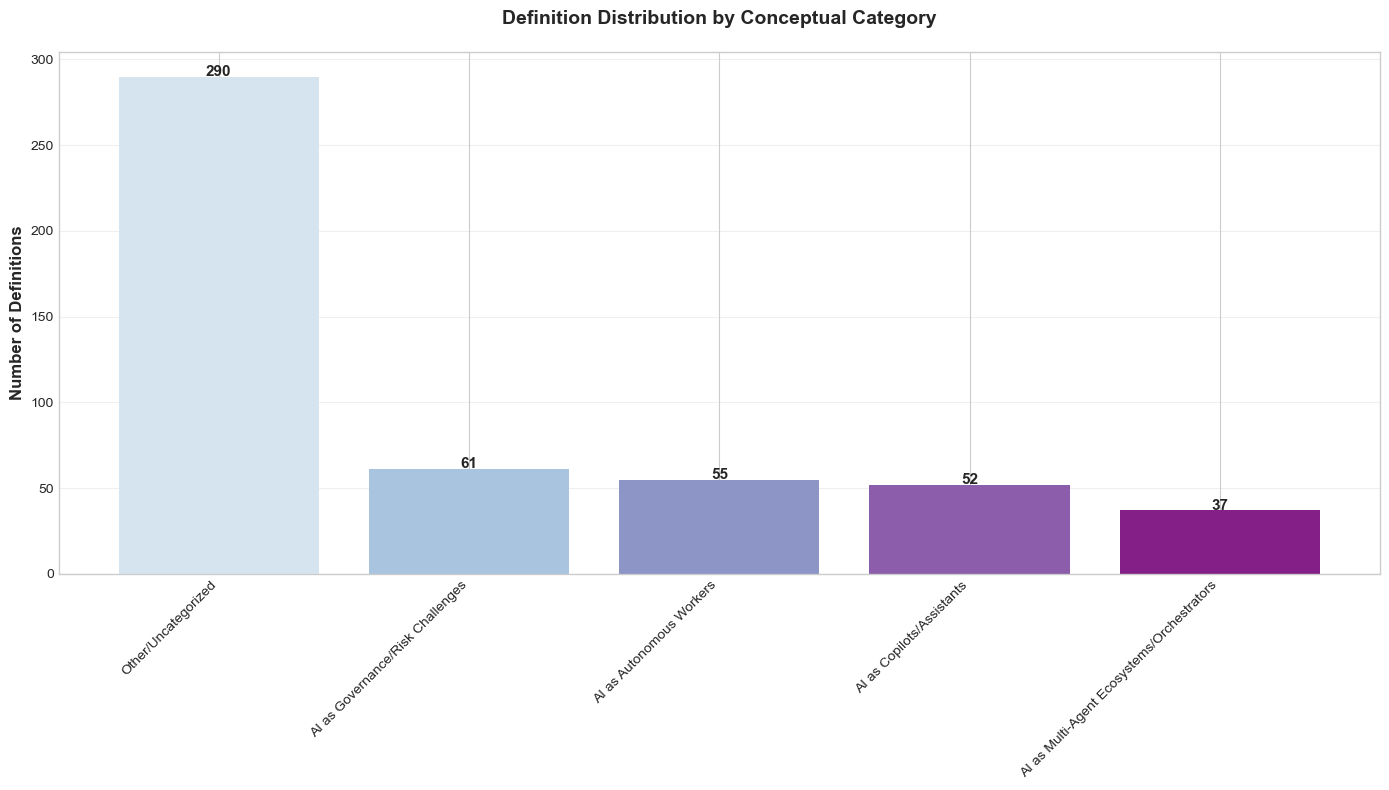

✔ Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_distribution.png


In [21]:
# Count definitions per category
category_counts = df_definitions[category_col].value_counts()

# Create mapping to full labels
category_labels = {cat_id: TAXONOMY_CATEGORIES[cat_id]['label'] 
                  for cat_id in category_counts.index}
category_counts.index = category_counts.index.map(category_labels)

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

colors = sns.color_palette('BuPu', len(category_counts))
bars = ax.bar(range(len(category_counts)), category_counts.values, 
             color=colors, linewidth=1.5)

ax.set_xticks(range(len(category_counts)))
ax.set_xticklabels(category_counts.index, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Number of Definitions', fontsize=12, fontweight='bold')
ax.set_title('Definition Distribution by Conceptual Category', 
            fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

for i, (bar, count) in enumerate(zip(bars, category_counts.values)):
    ax.text(i, count + 0.5, str(count), ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(TAXONOMY_DIR / 'taxonomy_distribution.png', bbox_inches='tight')
plt.show()

print(f"✔ Graph saved to: {TAXONOMY_DIR / 'taxonomy_distribution.png'}")

### Distribution per source type

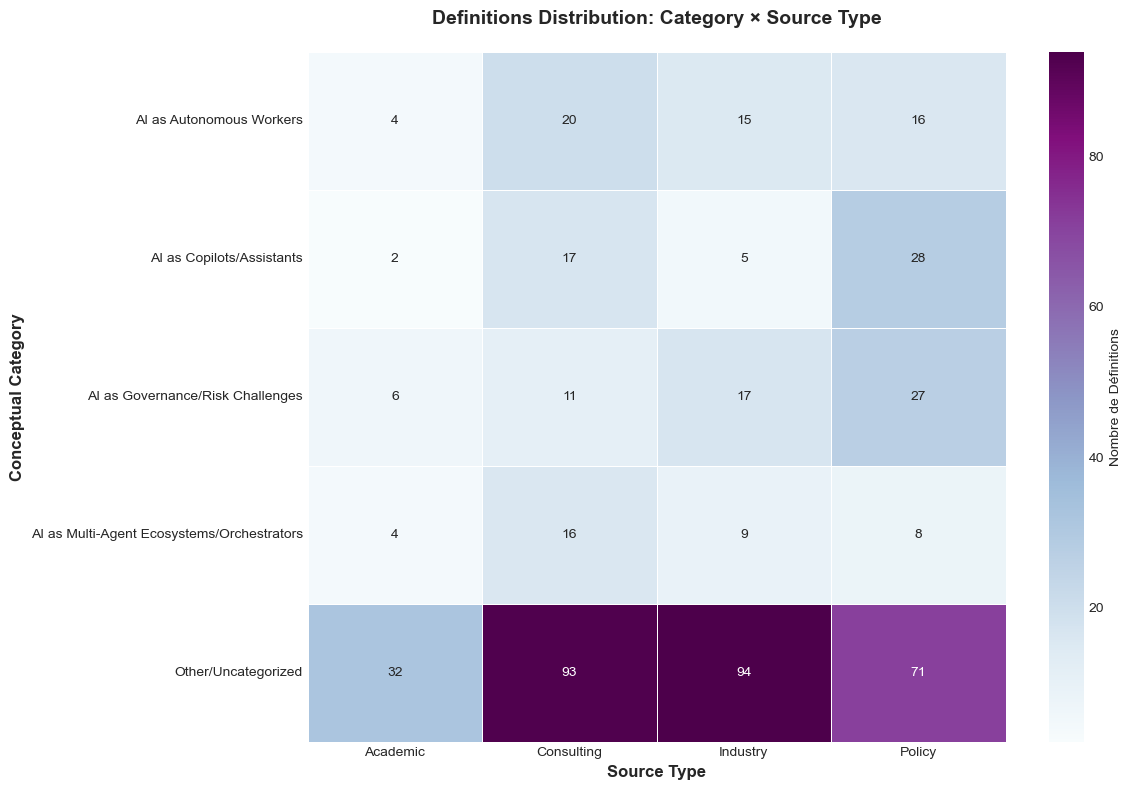

✔ Heatmap saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_by_source_heatmap.png


In [22]:
# Create matrix category × source type
cross_tab = pd.crosstab(
    df_definitions[category_col].map(lambda x: TAXONOMY_CATEGORIES[x]['label']),
    df_definitions['source_type']
)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(cross_tab, annot=True, fmt='d', cmap='BuPu', 
           linewidths=0.5, cbar_kws={'label': 'Nombre de Définitions'}, ax=ax)

ax.set_xlabel('Source Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Conceptual Category', fontsize=12, fontweight='bold')
ax.set_title('Definitions Distribution: Category × Source Type', 
            fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(TAXONOMY_DIR / 'taxonomy_by_source_heatmap.png', bbox_inches='tight')
plt.show()

print(f"✔ Heatmap saved to: {TAXONOMY_DIR / 'taxonomy_by_source_heatmap.png'}")

### Treemap

In [23]:
treemap_data = []

for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    count = (df_definitions[category_col] == cat_id).sum()
    if count > 0:
        treemap_data.append({
            'category': cat_info['label'],
            'count': count,
            'parent': 'Agentic AI Definitions'
        })
        
        # Ajouter les sous-niveaux par type de source
        for source_type in df_definitions['source_type'].unique():
            source_count = ((df_definitions[category_col] == cat_id) & 
                          (df_definitions['source_type'] == source_type)).sum()
            if source_count > 0:
                treemap_data.append({
                    'category': f"{source_type} ({source_count})",
                    'count': source_count,
                    'parent': cat_info['label']
                })

df_treemap = pd.DataFrame(treemap_data)

In [24]:
# Add root node
root_count = df_definitions.shape[0]
df_treemap = pd.concat([
    pd.DataFrame([{'category': 'Agentic AI Definitions', 'count': root_count, 'parent': ''}]),
    df_treemap
], ignore_index=True)

# Treemap using Plotly
fig = px.treemap(
    df_treemap,
    names='category',
    parents='parent',
    values='count',
    title='hierarchical Taxonomy of Agentic AI Definitions',
    color='count',
    color_continuous_scale='BuPu' ## RdYlBu_r
)

fig.update_layout(
    font=dict(size=14),
    title_font=dict(size=18, family='Arial Black'),
    height=700
)

fig.write_html(TAXONOMY_DIR / 'taxonomy_treemap.html')
fig.show()

print(f"✔ Treemap saved to: {TAXONOMY_DIR / 'taxonomy_treemap.html'}")

✔ Treemap saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_treemap.html


### Sunburst Chart

In [25]:
# Create sunburst chart
fig = px.sunburst(
    df_treemap,
    names='category',
    parents='parent',
    values='count',
    title='Definitions Taxonomy',
    color='count',
    color_continuous_scale='BuPu' ## Viridis
)

fig.update_layout(
    font=dict(size=13),
    title_font=dict(size=18, family='Arial Black'),
    height=700
)

fig.write_html(TAXONOMY_DIR / 'taxonomy_sunburst.html')
fig.show()

print(f"✔ Sunburst saved to: {TAXONOMY_DIR / 'taxonomy_sunburst.html'}")

✔ Sunburst saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_sunburst.html


### Sankey Graph (Flow: Source Type → Category)

In [26]:
source_types = df_definitions['source_type'].unique()
categories = df_definitions[category_col].unique()

# Mappings
source_to_idx = {s: i for i, s in enumerate(source_types)}
cat_to_idx = {c: i + len(source_types) for i, c in enumerate(categories)}

In [27]:
# Flows
sources = []
targets = []
values = []
labels = list(source_types) + [TAXONOMY_CATEGORIES[c]['label'] for c in categories]

for _, row in df_definitions.iterrows():
    source_idx = source_to_idx[row['source_type']]
    target_idx = cat_to_idx[row[category_col]]
    
    # Check if existing flow
    try:
        idx = sources.index(source_idx)
        if targets[idx] == target_idx:
            values[idx] += 1
            continue
    except ValueError:
        pass
    
    sources.append(source_idx)
    targets.append(target_idx)
    values.append(1)

In [ ]:
colors = sns.color_palette('BuPu', len(labels))
# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=['slategrey', 'lightsteelblue', 'cornflowerblue', 'lightskyblue', 
               'lavender', 'mediumpurple', 'darkorchid', 'mediumorchid'][:len(labels)]
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(
    title="Flux des Définitions: Type de Source → Catégorie Conceptuelle",
    font=dict(size=12),
    height=600
)

fig.write_html(TAXONOMY_DIR / 'taxonomy_sankey.html')
fig.show()

print(f"✔ Sankey saved to: {TAXONOMY_DIR / 'taxonomy_sankey.html'}")

✔ Sankey sauvegardé: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_sankey.html


## Categories comparative analysis

In [29]:
# Stats per category
for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    cat_defs = df_definitions[df_definitions[category_col] == cat_id]
    
    if len(cat_defs) == 0:
        continue
    
    print(f"{cat_info['label']}")
    
    print(f"  Total count      : {len(cat_defs)}")
    print(f"  Type distribution:")
    
    for source_type in cat_defs['source_type'].value_counts().index:
        count = (cat_defs['source_type'] == source_type).sum()
        pct = count / len(cat_defs) * 100
        print(f"    • {source_type:15} : {count:2} ({pct:5.1f}%)")

AI as Copilots/Assistants
  Total count      : 52
  Type distribution:
    • Policy          : 28 ( 53.8%)
    • Consulting      : 17 ( 32.7%)
    • Industry        :  5 (  9.6%)
    • Academic        :  2 (  3.8%)
AI as Autonomous Workers
  Total count      : 55
  Type distribution:
    • Consulting      : 20 ( 36.4%)
    • Policy          : 16 ( 29.1%)
    • Industry        : 15 ( 27.3%)
    • Academic        :  4 (  7.3%)
AI as Multi-Agent Ecosystems/Orchestrators
  Total count      : 37
  Type distribution:
    • Consulting      : 16 ( 43.2%)
    • Industry        :  9 ( 24.3%)
    • Policy          :  8 ( 21.6%)
    • Academic        :  4 ( 10.8%)
AI as Governance/Risk Challenges
  Total count      : 61
  Type distribution:
    • Policy          : 27 ( 44.3%)
    • Industry        : 17 ( 27.9%)
    • Consulting      : 11 ( 18.0%)
    • Academic        :  6 (  9.8%)
Other/Uncategorized
  Total count      : 290
  Type distribution:
    • Industry        : 94 ( 32.4%)
    • Consultin

In [ ]:
summary_text = f"""
MINI-TAXONOMY OF AGENTIC AI DEFINITIONS
{'='*70}

METHODOLOGY
{'-'*70}
• Semi-automatic extraction: {len(df_candidates)} candidate definitions
• Manual validation: {len(df_definitions)} definitions
• Categorization: 4 main conceptual categories

RESULTS
{'-'*70}
"""

for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    if cat_id == 'other':
        continue
    
    count = (df_definitions[category_col] == cat_id).sum()
    pct = count / len(df_definitions) * 100 if len(df_definitions) > 0 else 0
    
    summary_text += f"\n{cat_info['label']}: {count} definitions ({pct:.1f}%)\n"
    summary_text += f"  {cat_info['description']}\n"

summary_text += f"\n{'-'*70}\n"
summary_text += "KEY INSIGHTS\n"
summary_text += f"{'-'*70}\n"

# Identify dominant category
dominant_cat = df_definitions[category_col].value_counts().idxmax()
dominant_count = df_definitions[category_col].value_counts().max()
dominant_pct = dominant_count / len(df_definitions) * 100

summary_text += f"\n• Dominant category: {TAXONOMY_CATEGORIES[dominant_cat]['label']} ({dominant_pct:.1f}%)\n"

# Analyze per source type
summary_text += "\n• Differences per source type:\n"
for source_type in df_definitions['source_type'].unique():
    source_defs = df_definitions[df_definitions['source_type'] == source_type]
    if len(source_defs) > 0:
        top_cat = source_defs[category_col].value_counts().idxmax()
        summary_text += f"  - {source_type}: favors '{TAXONOMY_CATEGORIES[top_cat]['label']}'\n"

print(summary_text)


MINI-TAXONOMY OF AGENTIC AI DEFINITIONS

METHODOLOGY
----------------------------------------------------------------------
• Semi-automatic extraction: 495 candidate definitions
• Manual validation: 495 definitions
• Categorization: 4 main conceptual categories

RESULTS
----------------------------------------------------------------------

AI as Copilots/Assistants: 52 definitions (10.5%)
  AI agents that augment human work, provide suggestions, collaborate with users

AI as Autonomous Workers: 55 definitions (11.1%)
  AI agents that independently execute tasks with minimal human intervention

AI as Multi-Agent Ecosystems/Orchestrators: 37 definitions (7.5%)
  AI systems coordinating multiple agents, workflows, or complex processes

AI as Governance/Risk Challenges: 61 definitions (12.3%)
  AI agents framed through ethical, regulatory, or risk management lens

----------------------------------------------------------------------
KEY INSIGHTS
----------------------------------------

In [31]:
summary_file = TAXONOMY_DIR / 'taxonomy_summary.txt'
with open(summary_file, 'w', encoding='utf-8') as f:
    f.write(summary_text)

print(f"\n✔ Summary saved to: {summary_file}")


✔ Summary saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_summary.txt


## Save results

In [32]:
# Defs with categories
df_definitions.to_csv(TAXONOMY_DIR / 'definitions_categorized.csv', 
                     index=False, encoding='utf-8')
print(f"✔ Categorized definitions saved to: {TAXONOMY_DIR / 'definitions_categorized.csv'}")

✔ Categorized definitions saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\definitions_categorized.csv


In [33]:
# Table
report_table = []
for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    if cat_id == 'other':
        continue
    
    cat_defs = df_definitions[df_definitions[category_col] == cat_id]
    
    for _, row in cat_defs.iterrows():
        report_table.append({
            'Category': cat_info['label'],
            'Report': row['filename'],
            'Source_Type': row['source_type'],
            'Definition_Excerpt': row['text'][:200] + '...' if len(row['text']) > 200 else row['text']
        })

df_report_table = pd.DataFrame(report_table)
df_report_table.to_csv(TAXONOMY_DIR / 'taxonomy_table_for_report.csv', 
                       index=False, encoding='utf-8')
print(f"✔ Table saved to: {TAXONOMY_DIR / 'taxonomy_table_for_report.csv'}")

✔ Table saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_table_for_report.csv


In [34]:
# Aggregated stats
stats = {
    'total_definitions': len(df_definitions),
    'num_categories': len([c for c in TAXONOMY_CATEGORIES.keys() if c != 'other']),
    'category_distribution': {
        TAXONOMY_CATEGORIES[cat]['label']: int((df_definitions[category_col] == cat).sum())
        for cat in TAXONOMY_CATEGORIES.keys()
    },
    'by_source_type': {}
}

for source_type in df_definitions['source_type'].unique():
    source_defs = df_definitions[df_definitions['source_type'] == source_type]
    stats['by_source_type'][source_type] = {
        'total': len(source_defs),
        'distribution': {
            TAXONOMY_CATEGORIES[cat]['label']: int((source_defs[category_col] == cat).sum())
            for cat in TAXONOMY_CATEGORIES.keys()
        }
    }

with open(TAXONOMY_DIR / 'taxonomy_statistics.json', 'w') as f:
    json.dump(stats, f, indent=2)

print(f"✔ JSON stats saved to: {TAXONOMY_DIR / 'taxonomy_statistics.json'}")

✔ JSON stats saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_statistics.json
